<a href="https://colab.research.google.com/github/thamizhannal/eva5/blob/master/S7_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import torch
import torchvision
import torchvision.transforms as transforms

In [18]:
import torch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 256
num_workers = 1
pin_memory = True
input_size = (3,32,32)

In [19]:
from __future__ import print_function
import torch
from torchvision import datasets, transforms
import sys

#sys.path.append(".")
#import config

torch.manual_seed(1)
#kwargs = {'num_workers': config.num_workers, 'pin_memory': config.pin_memory} if config.use_cuda else {}
kwargs = {'num_workers': num_workers, 'pin_memory': pin_memory} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.RandomCrop(32, padding=4),
                       transforms.RandomHorizontalFlip(),
                       transforms.RandomRotation((-8.0, 8.0)),                                                 
                       #transforms.RandomRotation((-8.0, 8.0), fill=(1,)),
                       transforms.ToTensor(),
                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                   ])),
    #batch_size=config.batch_size, shuffle=True, **kwargs)
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('../data', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])),
    #batch_size=config.batch_size, shuffle=True, **kwargs)
    batch_size=batch_size, shuffle=True, **kwargs)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified


In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BatchNorm(nn.BatchNorm2d):
    def __init__(self, num_features, eps=1e-05, momentum=0.1, weight=True, bias=True):
        super().__init__(num_features, eps=eps, momentum=momentum)
        self.weight.data.fill_(1.0)
        self.bias.data.fill_(0.0)
        self.weight.requires_grad = weight
        self.bias.requires_grad = bias
class GhostBatchNorm(BatchNorm):
    def __init__(self, num_features, num_splits, **kw):
        super().__init__(num_features, **kw)
        self.num_splits = num_splits
        self.register_buffer('running_mean', torch.zeros(num_features * self.num_splits))
        self.register_buffer('running_var', torch.ones(num_features * self.num_splits))

    def train(self, mode=True):
        if (self.training is True) and (mode is False):  # lazily collate stats when we are going to use them
            self.running_mean = torch.mean(self.running_mean.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
            self.running_var = torch.mean(self.running_var.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
        return super().train(mode)

    def forward(self, input):
        N, C, H, W = input.shape
        if self.training or not self.track_running_stats:
            return F.batch_norm(
                input.view(-1, C * self.num_splits, H, W), self.running_mean, self.running_var,
                self.weight.repeat(self.num_splits), self.bias.repeat(self.num_splits),
                True, self.momentum, self.eps).view(N, C, H, W)
        else:
            return F.batch_norm(
                input, self.running_mean[:self.num_features], self.running_var[:self.num_features],
                self.weight, self.bias, False, self.momentum, self.eps)

In [21]:
#Create and view model architecture
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F

#sys.path.append(".")
#from batchnorm import GhostBatchNorm
#import config


def model_summary(model_, input_):
    from torchsummary import summary
    #use_cuda = config.use_cuda
    #device = config.device
    #use_cuda = use_cuda
    #device = device
    arch = model_.to(device)
    return summary(arch, input_)
class Net(nn.Module):
    # BN_flag 0: normal batchnorm; 1: Ghost batchnorm
    def batch_norm(self, channels, BN_flag):
        if BN_flag == 1:
            return GhostBatchNorm(channels, num_splits=2, weight=False)
        else:
            return nn.BatchNorm2d(channels)

    def __init__(self, BN_flag):
        super(Net, self).__init__()

        # Convolution Block-1 ###################################
        # Input:32x32  Outout:32x32 RF:3x3
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels=32, kernel_size=3, padding=1)  # input -? OUtput? RF #28,26,3
        self.batchnorm1 = self.batch_norm(32, BN_flag=1)
        
        # Input:32x32  Outout:32x32 RF:5x5
        self.conv2 = nn.Conv2d(in_channels = 32, out_channels=32, kernel_size=3, padding=1)  # 26,24,5
        self.batchnorm2 = self.batch_norm(32, BN_flag=1)

        self.dp2 = nn.Dropout(0.10)
        # Transition Block-1 ###################################
        # Input:32x32  Outout:16x16 RF:10x10
        self.pool1 = nn.MaxPool2d(2, 2)  # 24,12,10

        # Input:16x16  Outout:16x16 RF:10x10
        self.conv3 = nn.Conv2d(in_channels = 32, out_channels=16, kernel_size=1, padding=1) #20, 10, 1)  # 12,12,10
        self.batchnorm3 = self.batch_norm(16, BN_flag=1)
        self.dp3 = nn.Dropout(0.10)
      
        # Convolution Block-2 ###################################
        # Input:16x16  Outout:16x16 RF:12x12
        self.conv4 = nn.Conv2d(in_channels = 16, out_channels=64, kernel_size=(3,1), padding=1 )  # 12,10,12
        self.batchnorm4 = self.batch_norm(64, BN_flag=1)
        self.dp4 = nn.Dropout(0.10)

        # Input:16x16  Outout:16x16 RF:14x14
        self.conv5 = nn.Conv2d(in_channels = 64, out_channels=64, kernel_size=(1,3), padding=1)  # 10,8,12
        self.batchnorm5 = self.batch_norm(64, BN_flag=1)
        self.dp5 = nn.Dropout(0.10)
        
        # Input:16x16  Outout:8x8 RF:28x28
        self.pool2 = nn.MaxPool2d(2, 2)  # 24,12,10

        # Transition Block-2 ###################################
        # Input:8x8  Outout:8x8 RF:28x28
        self.conv6 = nn.Conv2d(in_channels = 64, out_channels=32, kernel_size=1, padding=1) #20, 10, 1)  # 12,12,10
        self.batchnorm6 = self.batch_norm(32, BN_flag=1)
        self.dp6 = nn.Dropout(0.10)
        
        # Convolution Block-3 ###################################
        # Input:8x8  Outout:8x8 RF:30x30
        self.conv7 = nn.Conv2d(in_channels = 32, out_channels=128, dilation=2, kernel_size=3,  padding=2)  # 12,10,12
        self.batchnorm7 = self.batch_norm(128, BN_flag=1)
        self.dp7 = nn.Dropout(0.10)

        # Input:8x8  Outout:8x8 RF:32x32
        self.conv8 = nn.Conv2d(in_channels = 128, out_channels=128, dilation=2, kernel_size=3, padding=1)  # 10,8,12
        self.batchnorm8 = self.batch_norm(128, BN_flag=1)
        self.dp8 = nn.Dropout(0.10)
        
        # MP
        # Input:8x8  Outout:4x4 RF:64x64
        self.pool3 = nn.MaxPool2d(2, 2)  # 24,12,10
        
        # Input:4x4  Outout:4x4 RF:66x66
        self.conv9 = nn.Conv2d(in_channels = 128, out_channels=256, kernel_size=3, padding=1)  # 10,8,12
        self.conv10 = nn.Conv2d(in_channels = 256, out_channels=64, kernel_size=3, padding=1)  # 10,8,12
        
        self.avgp = nn.AvgPool2d(kernel_size=4)
        self.conv11 = nn.Conv2d(64, 10, 1)  # 6,4,18

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.batchnorm1(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = self.batchnorm2(x)
        x = self.dp2(x)

        x = self.pool1(x)

        x = self.conv3(x)
        x = F.relu(x)
        x = self.batchnorm3(x)
        x = self.dp3(x)

        x = self.conv4(x)
        x = F.relu(x)
        x = self.batchnorm4(x)
        x = self.dp4(x)

        x = self.conv5(x)
        x = F.relu(x)
        x = self.batchnorm5(x)
        x = self.dp5(x)

        x = self.pool2(x)

        x = self.conv6(x)
        x = F.relu(x)
        x = self.batchnorm6(x)
        x = self.dp6(x)


        x = self.conv7(x)
        x = F.relu(x)
        x = self.batchnorm7(x)
        x = self.dp7(x)

        x = self.conv8(x)
        x = F.relu(x)
        x = self.batchnorm8(x)
        x = self.dp8(x)

        x = self.pool3(x)

        x = self.conv9(x)
        x = F.relu(x)
        #x = self.batchnorm9(x)
        

        x = self.conv10(x)
        x = F.relu(x)
        #x = self.batchnorm10(x)
        #x = self.dp8(x)

        x = self.avgp(x)
        x = self.conv11(x)

        x = x.view(-1, 10)
        return F.log_softmax(x)

In [22]:
from __future__ import print_function
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

test_loss_ = []
train_loss = 0


def train(model, device, train_loader, optimizer, epoch, l1_regularization=[1, 0.001]):
    model.train()
    train_correct = 0
    train_loss = 0
    type = l1_regularization[0]
    l = l1_regularization[1]
    pbar = tqdm(train_loader, leave=False, position=0)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        output = model(data)
        optimizer.zero_grad()

        if type == 1:
            l1_regularization = 0
            for param in model.parameters():
                l1_regularization += torch.sum(abs(param))
            train_loss = F.nll_loss(output, target) + l * l1_regularization
        else:
            train_loss = F.nll_loss(output, target)

        train_loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        train_correct += pred.eq(target.view_as(pred)).sum().item()
        pbar.set_description(desc=f'loss={train_loss.item()} batch_id={batch_idx}')

    print('Epoch: {:.0f},LR: {}.\nTrain set: train Average loss: {:.4f}, train_Accuracy: {}/{} ({:.4f}%)\n'.format(
        epoch, optimizer.param_groups[0]['lr'], train_loss, train_correct, len(train_loader.dataset),
        100. * train_correct / len(train_loader.dataset)))


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    return 100. * correct / len(test_loader.dataset), test_loss

In [23]:
from __future__ import print_function
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import sys

#sys.path.append(".")

#import config
#from model import Net, model_summary
#from Engine_train_test import train, test
#from dataloader import train_loader,test_loader

#print(model_summary(Net(1), config.input_size))
print(model_summary(Net(1), input_size))

accu = []
loss_test = []


model_ = Net(BN_flag=1).to(device)
optimizer = optim.SGD(model_.parameters(), lr=0.016, momentum=0.9)
scheduler = StepLR(optimizer, step_size=2, gamma=0.92)

valid_acc = []
loss_test_ = []
l1_regularization = [0, 0]
for epoch in range(1, 26):
    train(model_, device, train_loader, optimizer, epoch, l1_regularization)
    scheduler.step()
    valid_a, valid_l = test(model_, device, test_loader)
    # Appending to loss and accuracy lists
    valid_acc.append(valid_a)
    loss_test_.append(valid_l)

accu.append(valid_acc)
loss_test.append(loss_test_)

import pickle
#with open("D:/ML/EVA/JEDI/model_objects/model_op_params.pickle","wb") as f:
with open("model_op_params.pickle","wb") as f:
    pickle.dump(accu, f)
    pickle.dump(loss_test, f)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:153: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  0%|          | 0/196 [00:00<?, ?it/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
    GhostBatchNorm-2           [-1, 32, 32, 32]              64
            Conv2d-3           [-1, 32, 32, 32]           9,248
    GhostBatchNorm-4           [-1, 32, 32, 32]              64
           Dropout-5           [-1, 32, 32, 32]               0
         MaxPool2d-6           [-1, 32, 16, 16]               0
            Conv2d-7           [-1, 16, 18, 18]             528
    GhostBatchNorm-8           [-1, 16, 18, 18]              32
           Dropout-9           [-1, 16, 18, 18]               0
           Conv2d-10           [-1, 64, 18, 20]           3,136
   GhostBatchNorm-11           [-1, 64, 18, 20]             128
          Dropout-12           [-1, 64, 18, 20]               0
           Conv2d-13           [-1, 64, 20, 20]          12,352
   GhostBatchNorm-14           [-1, 64,

Epoch: 1,LR: 0.016.
Train set: train Average loss: 1.4127, train_Accuracy: 16959/50000 (33.9180%)



  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 1.4475, Accuracy: 4514/10000 (45.1400%)



Epoch: 2,LR: 0.016.
Train set: train Average loss: 1.0323, train_Accuracy: 26061/50000 (52.1220%)



  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 1.3139, Accuracy: 5464/10000 (54.6400%)



Epoch: 3,LR: 0.01472.
Train set: train Average loss: 1.1015, train_Accuracy: 29594/50000 (59.1880%)



  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 1.1918, Accuracy: 5909/10000 (59.0900%)



Epoch: 4,LR: 0.01472.
Train set: train Average loss: 0.8155, train_Accuracy: 31427/50000 (62.8540%)



  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.9341, Accuracy: 6688/10000 (66.8800%)



Epoch: 5,LR: 0.013542400000000001.
Train set: train Average loss: 0.8449, train_Accuracy: 32998/50000 (65.9960%)



  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.9982, Accuracy: 6613/10000 (66.1300%)



Epoch: 6,LR: 0.013542400000000001.
Train set: train Average loss: 0.9354, train_Accuracy: 33931/50000 (67.8620%)



  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.8246, Accuracy: 7153/10000 (71.5300%)



Epoch: 7,LR: 0.012459008000000002.
Train set: train Average loss: 0.8545, train_Accuracy: 35132/50000 (70.2640%)



  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.8049, Accuracy: 7206/10000 (72.0600%)



Epoch: 8,LR: 0.012459008000000002.
Train set: train Average loss: 0.7456, train_Accuracy: 36050/50000 (72.1000%)



  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.7607, Accuracy: 7388/10000 (73.8800%)



Epoch: 9,LR: 0.011462287360000002.
Train set: train Average loss: 0.8403, train_Accuracy: 36801/50000 (73.6020%)



  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.7991, Accuracy: 7373/10000 (73.7300%)



Epoch: 10,LR: 0.011462287360000002.
Train set: train Average loss: 0.6683, train_Accuracy: 37152/50000 (74.3040%)



  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.6961, Accuracy: 7623/10000 (76.2300%)



Epoch: 11,LR: 0.010545304371200001.
Train set: train Average loss: 0.5170, train_Accuracy: 38021/50000 (76.0420%)



  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.6282, Accuracy: 7835/10000 (78.3500%)



Epoch: 12,LR: 0.010545304371200001.
Train set: train Average loss: 0.9084, train_Accuracy: 38327/50000 (76.6540%)



  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.6316, Accuracy: 7922/10000 (79.2200%)



Epoch: 13,LR: 0.009701680021504002.
Train set: train Average loss: 0.7153, train_Accuracy: 38786/50000 (77.5720%)



  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.6077, Accuracy: 7980/10000 (79.8000%)



Epoch: 14,LR: 0.009701680021504002.
Train set: train Average loss: 0.5088, train_Accuracy: 39011/50000 (78.0220%)



  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.6358, Accuracy: 7925/10000 (79.2500%)



Epoch: 15,LR: 0.008925545619783683.
Train set: train Average loss: 0.5348, train_Accuracy: 39433/50000 (78.8660%)



  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.6289, Accuracy: 7917/10000 (79.1700%)



Epoch: 16,LR: 0.008925545619783683.
Train set: train Average loss: 0.5986, train_Accuracy: 39577/50000 (79.1540%)



  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.5970, Accuracy: 7988/10000 (79.8800%)



Epoch: 17,LR: 0.008211501970200989.
Train set: train Average loss: 0.6573, train_Accuracy: 39915/50000 (79.8300%)



  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.5707, Accuracy: 8120/10000 (81.2000%)



Epoch: 18,LR: 0.008211501970200989.
Train set: train Average loss: 0.4234, train_Accuracy: 40127/50000 (80.2540%)



  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.6029, Accuracy: 8048/10000 (80.4800%)



Epoch: 19,LR: 0.007554581812584909.
Train set: train Average loss: 0.6119, train_Accuracy: 40329/50000 (80.6580%)



  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.5695, Accuracy: 8152/10000 (81.5200%)



Epoch: 20,LR: 0.007554581812584909.
Train set: train Average loss: 0.4661, train_Accuracy: 40506/50000 (81.0120%)



  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.5545, Accuracy: 8223/10000 (82.2300%)



Epoch: 21,LR: 0.006950215267578117.
Train set: train Average loss: 0.4653, train_Accuracy: 40648/50000 (81.2960%)



  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.5404, Accuracy: 8201/10000 (82.0100%)



Epoch: 22,LR: 0.006950215267578117.
Train set: train Average loss: 0.6823, train_Accuracy: 40842/50000 (81.6840%)



  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.5471, Accuracy: 8243/10000 (82.4300%)



Epoch: 23,LR: 0.006394198046171868.
Train set: train Average loss: 0.7008, train_Accuracy: 41097/50000 (82.1940%)



  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.5576, Accuracy: 8229/10000 (82.2900%)



Epoch: 24,LR: 0.006394198046171868.
Train set: train Average loss: 0.7009, train_Accuracy: 41113/50000 (82.2260%)



  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.5459, Accuracy: 8221/10000 (82.2100%)



Epoch: 25,LR: 0.005882662202478119.
Train set: train Average loss: 0.4471, train_Accuracy: 41292/50000 (82.5840%)




Test set: Average loss: 0.5437, Accuracy: 8257/10000 (82.5700%)



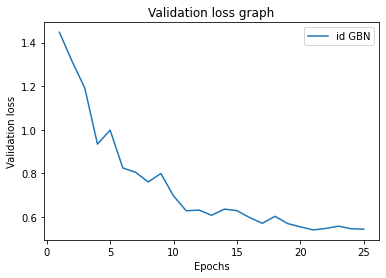

In [24]:
import matplotlib.pyplot as plt

x = [i for i in range(1,26)]
y = loss_test
Modelgraph = ['GBN']

plt.title("Validation loss graph")
plt.xlabel("Epochs")
plt.ylabel("Validation loss")
#plt.figure(figsize=(10,10))

for i in range(len(y)):
    plt.plot(x,y[i],label = 'id %s'%Modelgraph[i])

plt.legend()
#plt.show()
plt.savefig('Validation loss graph')

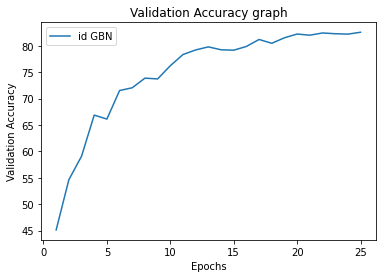

<Figure size 432x288 with 0 Axes>

In [25]:
import matplotlib.pyplot as plt

x = [i for i in range(1,26)]
y = accu
Modelgraph = ['GBN']


plt.title("Validation Accuracy graph")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")


for i in range(len(y)):
    plt.plot(x,y[i],label = 'id %s'%Modelgraph[i])

plt.legend()
plt.show()
plt.savefig('Validation Accuracy graph_')